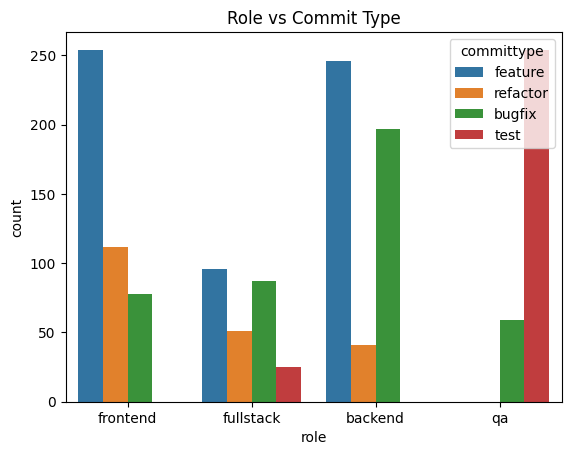

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(data=f, x='role', hue='committype')
plt.title("Role vs Commit Type")
plt.show()

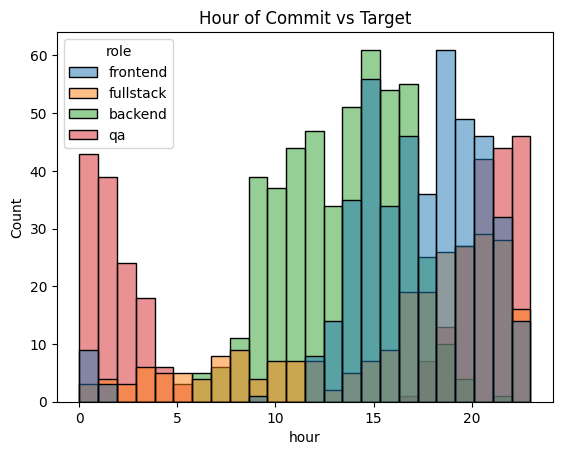

In [ ]:
sns.histplot(data=f, x='hour', hue='role', bins=24)
plt.title("Hour of Commit vs Target")
plt.show()

In [ ]:
!pip install ydata-profiling

In [ ]:
from ydata_profiling import ProfileReport
profile = ProfileReport(f, title="Profiling Report")
profile.to_file("report.html")

In [ ]:
profile.to_notebook_iframe()

Let's start the model training

In [ ]:

from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
numeric_and_ext = f.drop(columns=['new_committype',
 'scaled_net_lines',
 'scaled_files_changed',
 'scaled_numcommentsadded',
  'day_mapped', 'hour_sin'])



In [ ]:

from scipy.sparse import hstack
# Clean each column individually
numeric_cleaned = numeric_and_ext.copy()

for col in numeric_cleaned.columns:
    numeric_cleaned[col] = pd.to_numeric(numeric_cleaned[col], errors='coerce').fillna(0)

from scipy.sparse import csr_matrix
numeric_sparse = csr_matrix(numeric_cleaned.values.astype(np.float64))
X = hstack([numeric_sparse, tfidf_matrix])
y = f['role_encoded']

Train, test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1. Initialize the model
lr = LogisticRegression(max_iter=1000)  # increase max_iter to avoid convergence issues

# 2. Train the model
lr.fit(X_train, y_train)

# 3. Make predictions
y_pred = lr.predict(X_test)

# 4. Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9866666666666667
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        97
           1       1.00      0.98      0.99        89
           2       0.93      1.00      0.96        52
           3       1.00      0.97      0.98        62

    accuracy                           0.99       300
   macro avg       0.98      0.99      0.98       300
weighted avg       0.99      0.99      0.99       300



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


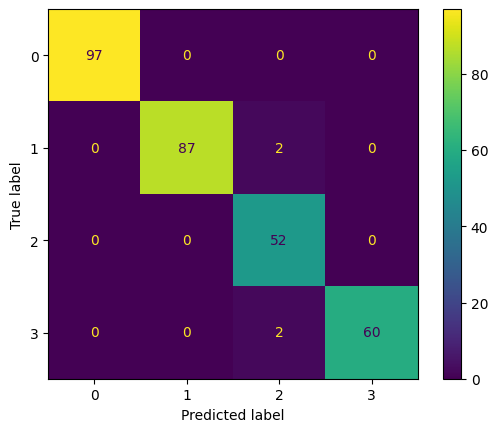

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [ ]:
import numpy as np

# Assuming you trained it like:
# model = LogisticRegression(max_iter=1000)
# model.fit(X_train, y_train)

# Coefficients
coefficients = lr.coef_
intercepts = lr.intercept_

print("Shape of coefficients:", coefficients.shape)
print("Intercepts:", intercepts)


Shape of coefficients: (4, 816)
Intercepts: [ 0.61578188  0.01266387 -0.67447998  0.04603423]


In [ ]:
# Numeric + one-hot feature names
num_ext_features = numeric_and_ext.columns.tolist()

# TF-IDF feature names
tfidf_features = vectorizer.get_feature_names_out()

# Combine them
all_features = num_ext_features + list(tfidf_features)

# Map feature -> coefficient
coef_df = pd.DataFrame({
    "feature": all_features,
    "coefficient": coefficients[0]  # for binary classification
}).sort_values(by="coefficient", ascending=False)

print(coef_df.head(59))   # top positive
print(coef_df.tail(20))   # top negative


                      feature  coefficient
443                     logic     0.305141
85             authentication     0.298165
235                  endpoint     0.288958
201                  database     0.267333
652                   session     0.266378
90       authentication logic     0.265388
787                validation     0.248575
554                     query     0.244754
459                     login     0.240862
68                        api     0.236756
722                     token     0.232240
621                    schema     0.230951
296      fixed authentication     0.197385
7            numcommentsadded     0.187237
643                   service     0.184156
95                    backend     0.179889
203            database query     0.179344
463            login endpoint     0.161663
473                management     0.154468
175                controller     0.154452
656        session management     0.153724
74               api endpoint     0.152755
727        